# Causal Inference Using Pearl's Framework

## Objectives:

- Perform a causal inference task using Pearl’s framework;
- Infer the causal graph from observational data and then validate the graph;
- Merge machine learning with causal inference;


## Load Data and Libraries

In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from IPython.display import Image
import copy

import warnings
warnings.filterwarnings("ignore")


In [2]:
# add scripts
sys.path.append(os.path.abspath("../scripts/"))

from utils import Utils
Util = Utils()

In [3]:
# Load Data

raw_df = pd.read_csv("../data/data.csv")
raw_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
# Check Dataset

raw_df.shape

(569, 33)

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

### Observation
- There are 569 rows and 33 columns
- The last column is completely empty
- There is no Null value in any of the other columns.
- All the variables are float type except for the Id column and the diagnosis variable which is string.

## Clean Data

In [6]:
# removing null column and id
clean_df = raw_df.iloc[:,1:-1]
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

### check for outliers

In [7]:
test = Util.check_outlier(clean_df.iloc[:,1:])
test

,columns,minor_outlier,major_outlier
0,radius_mean,14,0
1,texture_mean,7,0
2,perimeter_mean,13,0
3,area_mean,25,0
4,smoothness_mean,6,0
5,compactness_mean,16,0
6,concavity_mean,18,0
7,concave points_mean,10,0
8,symmetry_mean,15,0
9,fractal_dimension_mean,15,0


### Observation
- There are no major outliers
- There are some minor outliers in each row
- There are no Null values

## Perform Exploratory Analysis

### Univariate Analysis

In [8]:
# Univariate Analysis
Util.describe(clean_df)

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.000000,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.110000
texture_mean,569.000000,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.280000
perimeter_mean,569.000000,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.500000
area_mean,569.000000,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.000000
smoothness_mean,569.000000,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.163400
compactness_mean,569.000000,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.345400
concavity_mean,569.000000,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.426800
concave points_mean,569.000000,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.201200
symmetry_mean,569.000000,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.304000
fractal_dimension_mean,569.000000,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.097440


Number of Benign:  357
Number of Malignant :  212


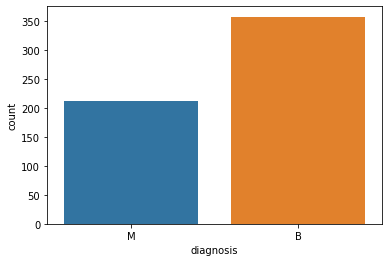

In [9]:
# check the target variable
target = clean_df["diagnosis"]
ax = sns.countplot(target,label="Count")       # M = 212, B = 357
B, M = target.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

### Observation
- Important summary statistics of all the numerical variables like the mean, std, min, 25%, 50%, 75%, and max values.
- There is high variation in values in area_mean and area_worst.
- There are many variables have median value 0.
- The area_worst feature’s max value is 4254 and fractal_dimension_se features’ max 0.029840. This indicates we need to standardize or normalize data before visualization, feature selection, and classification.
- Bar plot of diagnosis shows that Malignant and Benign patients ratio is 37% (212/569) and 63% (357/569) respectively.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'radius_mean'),
  Text(1, 0, 'texture_mean'),
  Text(2, 0, 'perimeter_mean'),
  Text(3, 0, 'area_mean'),
  Text(4, 0, 'smoothness_mean'),
  Text(5, 0, 'compactness_mean'),
  Text(6, 0, 'concavity_mean'),
  Text(7, 0, 'concave points_mean'),
  Text(8, 0, 'symmetry_mean'),
  Text(9, 0, 'fractal_dimension_mean'),
  Text(10, 0, 'radius_se'),
  Text(11, 0, 'texture_se'),
  Text(12, 0, 'perimeter_se'),
  Text(13, 0, 'area_se'),
  Text(14, 0, 'smoothness_se'),
  Text(15, 0, 'compactness_se'),
  Text(16, 0, 'concavity_se'),
  Text(17, 0, 'concave points_se'),
  Text(18, 0, 'symmetry_se'),
  Text(19, 0, 'fractal_dimension_se'),
  Text(20, 0, 'radius_worst'),
  Text(21, 0, 'texture_worst'),
  Text(22, 0, 'perimeter_worst'),
  Text(23, 0, 'area_worst'),
  Text(24, 0, 'smoothness_worst'),
  Text(25, 0, 'compactness_worst'),
  Text(26, 0, 'concavity_

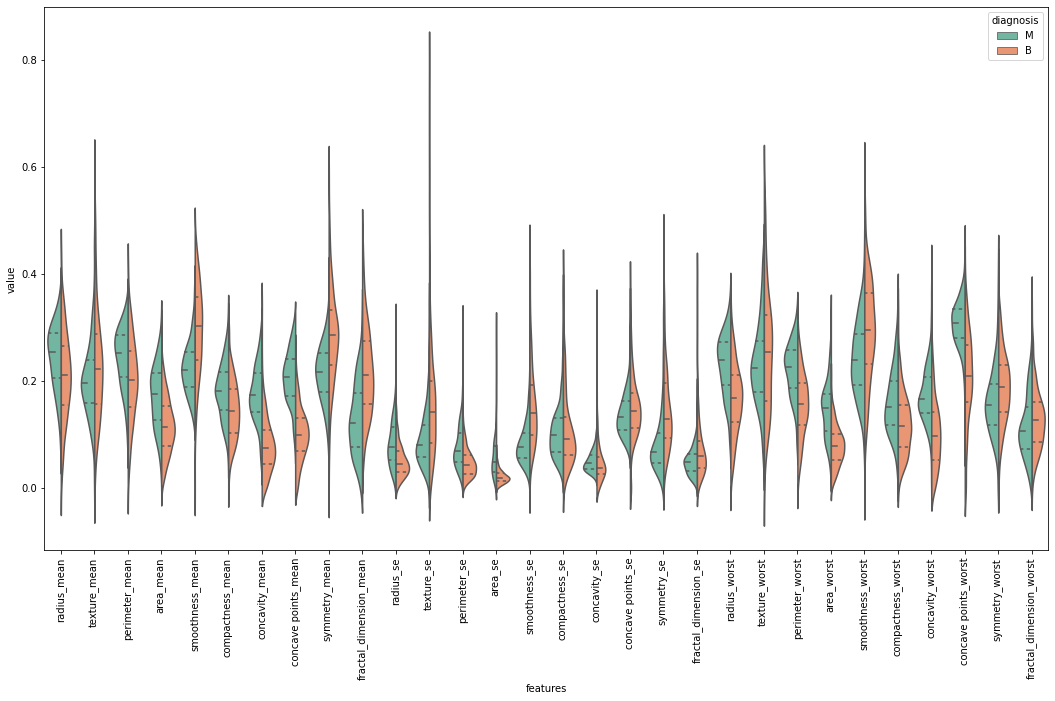

In [10]:
clean_df.iloc[:,1:] = Util.scale_and_normalize(clean_df.iloc[:,1:]) 
data = pd.concat([clean_df.iloc[:,:]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(18,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart",palette ="Set2")
plt.xticks(rotation=90)

### Observation
- Some variables can be used to classify diagnosis clearly becuase their distributions for Benign and Malignant cancer is
  clearly separated

### Bivariate Analysis

<Figure size 1152x1224 with 0 Axes>

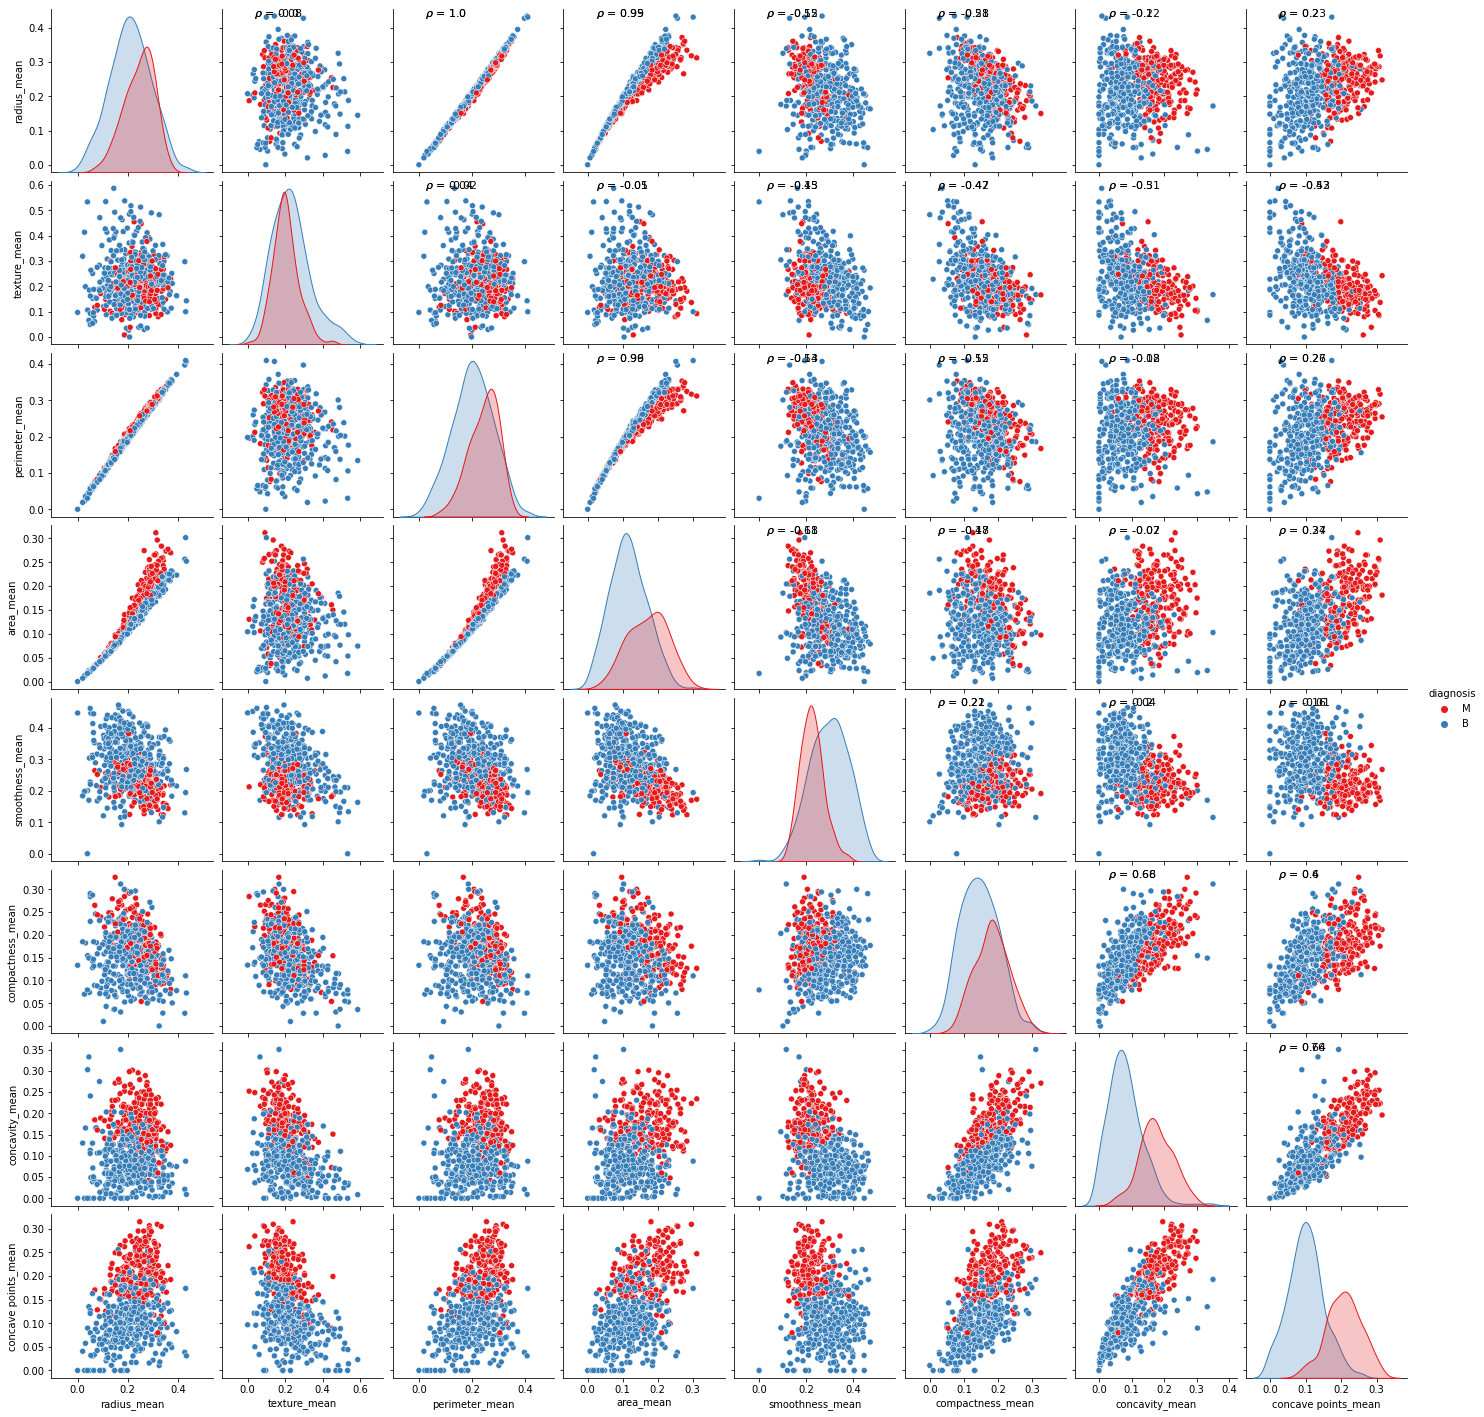

In [11]:
Util.plot_pair(clean_df, [0,8], [16,17])

<Figure size 1152x1224 with 0 Axes>

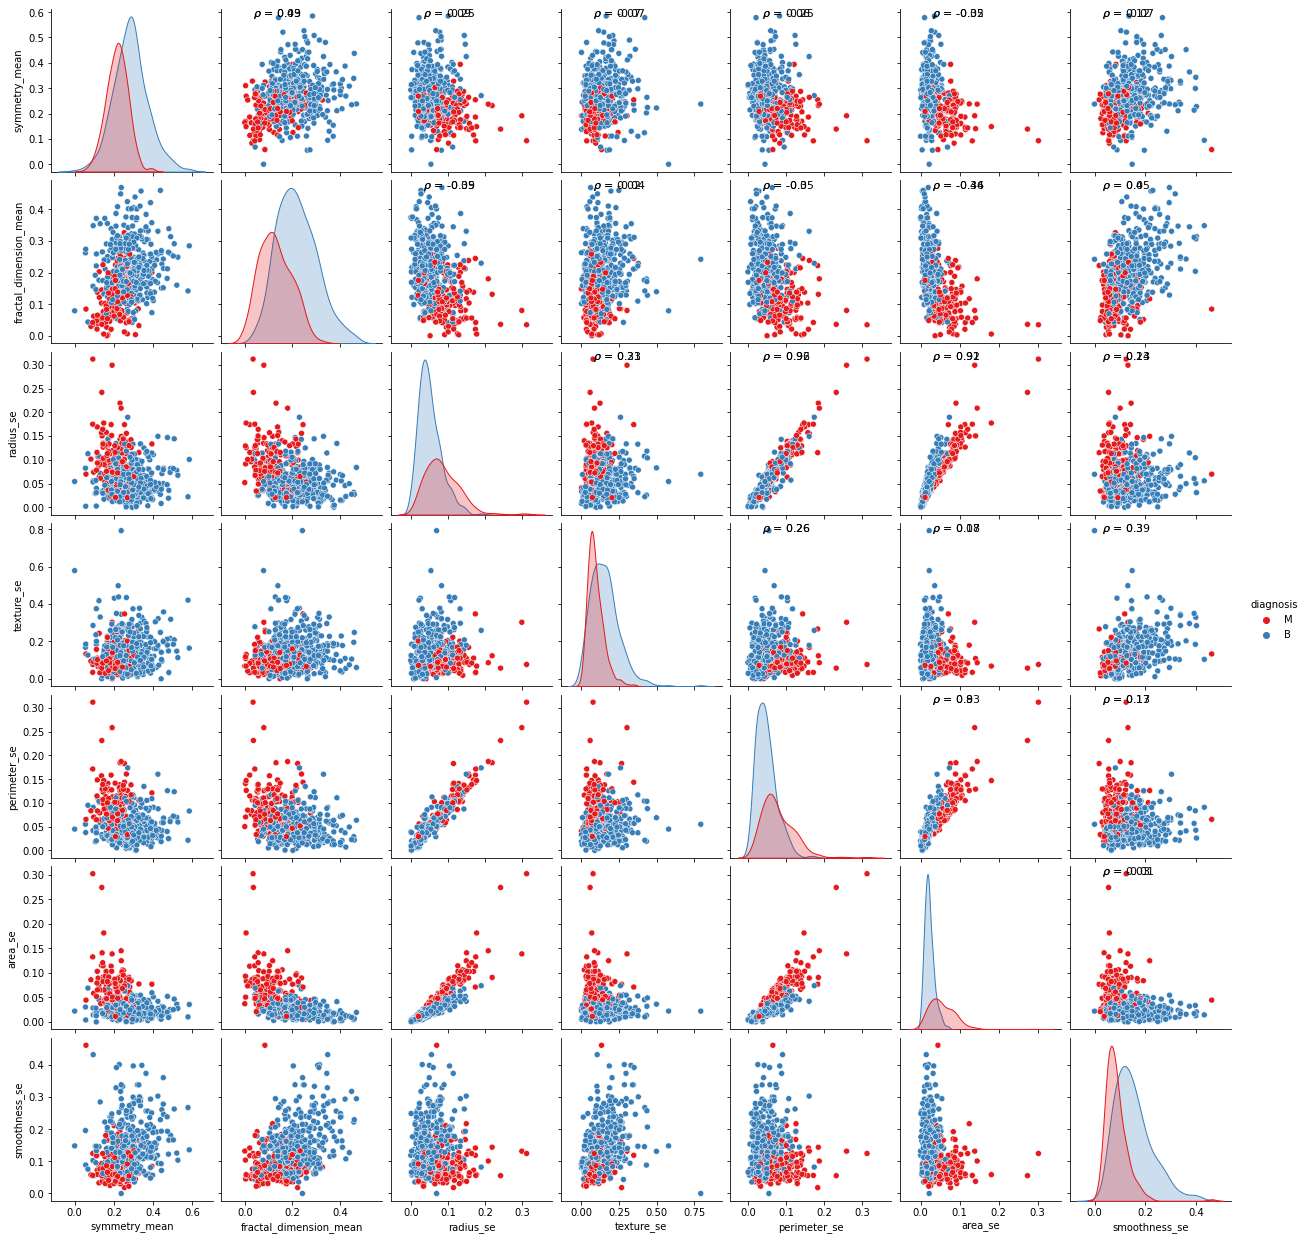

In [12]:
Util.plot_pair(clean_df, [8,15], [16,17])

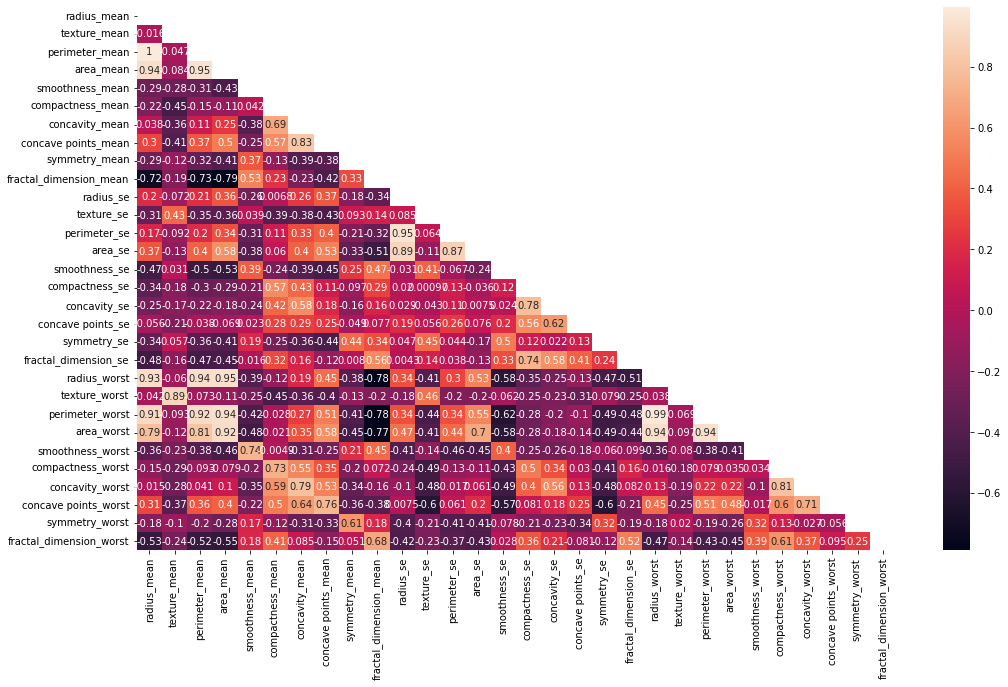

In [13]:
# bivariate Analysis
# correlation matrix

Util.show_corr(clean_df)

### Observation
- The Distribution of the variables is right skewed
- There is a large correlation between radius and concave points, concavity and conpactness
- there is a large positive correlation between smoothness and compactness, fractal dimension.

In [15]:
clean_df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,0.186819,0.008124,0.195765,0.130417,0.212891,0.283987,0.252112,0.262142,0.246097,...,0.222580,0.050744,0.239624,0.161599,0.215539,0.222048,0.203877,0.327010,0.214580,0.150185
1,M,0.350623,0.148599,0.335707,0.273452,0.158034,0.099095,0.111001,0.190132,0.207055,...,0.330865,0.165498,0.294293,0.237266,0.189476,0.084263,0.105202,0.348459,0.127346,0.121507
2,M,0.265229,0.172085,0.262692,0.198170,0.226784,0.190056,0.203944,0.280305,0.224706,...,0.245338,0.158775,0.224197,0.165139,0.213238,0.169931,0.158629,0.368215,0.178014,0.094113
3,M,0.068534,0.117710,0.076171,0.033569,0.264663,0.264676,0.184507,0.170564,0.253227,...,0.081002,0.125894,0.078730,0.030667,0.298639,0.265541,0.178974,0.288659,0.326213,0.252394
4,M,0.321793,0.079991,0.322352,0.249963,0.219853,0.177728,0.237001,0.264830,0.193253,...,0.265521,0.063314,0.258984,0.174500,0.223436,0.088082,0.163217,0.285279,0.080462,0.072847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,0.293842,0.182614,0.289016,0.241245,0.224405,0.126078,0.243362,0.293995,0.143243,...,0.265423,0.163215,0.245369,0.192771,0.196379,0.076027,0.139697,0.324296,0.041553,0.044999
565,M,0.297467,0.299697,0.288727,0.226579,0.194918,0.123186,0.161273,0.232607,0.167057,...,0.267991,0.334164,0.248985,0.181598,0.143402,0.076478,0.122744,0.267415,0.094883,0.035522
566,M,0.276412,0.377192,0.270666,0.184042,0.174963,0.154426,0.131604,0.159999,0.162523,...,0.238675,0.357631,0.230691,0.140092,0.171327,0.166183,0.165030,0.295861,0.078154,0.092233
567,M,0.209616,0.215777,0.216436,0.154705,0.191330,0.256976,0.267753,0.245682,0.219596,...,0.206044,0.237490,0.217338,0.130744,0.201506,0.265289,0.243826,0.296149,0.161673,0.147095


In [14]:
clean_df.to_csv("../data/clean_data.csv")